# Introduction

Brian & barbara wanted a boxplot of genes detected (>= 1.0 FPKM) for the 920 cells in the muscle development paper

Box plot (see seaborn) y axis is number of genes > 1 fpkm.
can use protein coding. should include that in axis.

In [1]:
import pandas
import sys
import os
import seaborn
from matplotlib import pyplot

In [2]:
LONG_RNA_SEQ_DIR = os.path.expanduser('~diane/proj/long-rna-seq-condor')
if LONG_RNA_SEQ_DIR not in sys.path:
    sys.path.append(LONG_RNA_SEQ_DIR)

In [3]:
from woldrnaseq.models import load_gtf_cache
from woldrnaseq.gtfcache import protein_coding_gene_ids

In [4]:
PANDASODF = os.path.expanduser('~diane/src/pandasodf')
if PANDASODF not in sys.path:
    sys.path.append(PANDASODF)
from pandasodf import ODFReader

In [5]:
from find_bigwigs import read_peng_20180710_cluster_memberships

In [6]:
%matplotlib inline

In [7]:
annotation = load_gtf_cache(os.path.expanduser('~diane/proj/genome/mm10-M4-male/mm10-M4-male.h5'))
protein_coding = protein_coding_gene_ids(annotation)

In [8]:
genes_asof17 = pandas.read_csv('C1_mouse_combined_asof_run17.tsv',
                               dtype={0: str},
                               index_col=0,
                               sep='\t')

In [9]:
book = ODFReader('C1_single_cells_library_number_cell_type_annotation_Jan13_2019.ods')
clusters = book.parse('Sheet1')
clusters = clusters[['cell_ID', 'cell type cluster 920']]
clusters.shape

(920, 2)

In [10]:
clusters.head()

,cell_ID,cell type cluster 920
0,18317_G10,DarkRed
1,20040_B1,DarkRed
2,20044_A10,DarkRed
3,20042_D4,DarkRed
4,18255_E8,DarkRed


Lets make sure that all the cells in the C1_single_cells_library_number_type_annotation_Jan13_2019 are in the full quantification data table

In [11]:
len(set(clusters.cell_ID).intersection(genes_asof17.columns))

920

In [12]:
protein_genes = genes_asof17.loc[protein_coding][clusters.cell_ID]
protein_genes.shape

(22032, 920)

In [13]:
order = ['DarkRed', 'red', 'green', 'black', 'grey', 'cyan', 'orange', 'yellow', 
         'purple', 'blue', 'YellowGreen', 'magenta']

#cluster_order = ['Muscle 3', 'Muscle 2', 'Muscle 1', 'Mesenchyme2 + Unknown', 'Mesenchyme', 'Chondrocyte',  
#                 'EMP', 'Macrophage', 'Endothelial', 'Perichondrium', 'Epithelial', 'Neural Crest']

In [14]:
expressed = protein_genes[protein_genes >= 1]
expressed.shape

(22032, 920)

In [15]:
def color_to_cluster_name():
    peng = {}
    for row in read_peng_20180710_cluster_memberships():
        cluster = row['cluster_name']
        peng[row['value']] = cluster
    return peng

def cluster_name_to_color():
    peng = {}
    for row in read_peng_20180710_cluster_memberships():
        cluster = row['cluster_name']
        peng[cluster] = row['value']
    return peng

def build_multi_index(clusters, protein_genes):
    peng_color_names = color_to_cluster_name()
    cells = []
    for cell_id in protein_genes.columns:
        row_index = clusters[clusters['cell_ID'] == cell_id].first_valid_index()
        color = clusters.loc[row_index]['cell type cluster 920']
        cluster_name = peng_color_names[color]
        cells.append((cluster_name, cell_id))
    index = pandas.MultiIndex.from_tuples(cells)
    return index


In [16]:
cluster_columns = build_multi_index(clusters, protein_genes)
expressed.columns = cluster_columns

In [17]:
def build_color_palatte(order):
    cluster_colors = pandas.read_csv('violin-paper/peng-violin-plot-colors.csv')
    peng_cluster_colors = cluster_name_to_color()
    flat_colors = []
    for cluster_name in order:
        color = peng_cluster_colors[cluster_name]
        row_index = cluster_colors[cluster_colors['cell type'] == cluster_name].first_valid_index()
        flat_colors.append(cluster_colors.iloc[row_index]['hex'])
    return flat_colors

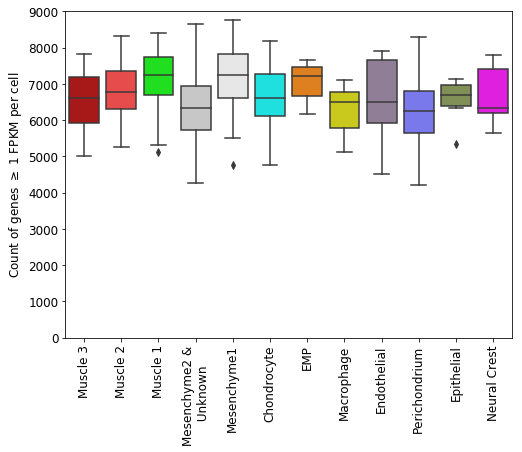

In [18]:
def plot_boxplot(expressed):
    font_size = 12.0
    order = expressed.columns.get_level_values(0).to_series().unique()
    flat_colors = build_color_palatte(order)
    flat_expressed = expressed.count().reset_index()
    flat_expressed.columns=['cluster', 'cell_ID', 'count']
    
    f = pyplot.figure(figsize=(8,6))
    ax = f.add_subplot(1,1,1)
    _ = seaborn.boxplot(x='cluster', y='count', palette=flat_colors, data=flat_expressed, ax=ax)
    _ = ax.set_ylabel('Count of genes $\geq$ 1 FPKM per cell', size=font_size)
    _ = ax.set_xlabel('')
    
    labels = ax.get_yticklabels()
    for l in labels:
        l.set_fontsize(font_size)
    
    labels = ax.get_xticklabels()
    for l in labels:
        l.set_text(l.get_text().replace('+', '&\n'))
        l.set_fontsize(font_size)
    _ = ax.set_xticklabels(labels, rotation=90, ha='center')
    _ = ax.set_ylim(0, 9000)
    return f, ax
f, ax = plot_boxplot(expressed)

In [19]:
ax.get_xticklabels()[0].get_fontsize()

12.0

In [20]:
#f.savefig('count_of_genes_gt_1_fpkm_920cells.png')

In [21]:
cluster_order = ['Muscle 3', 'Muscle 2', 'Muscle 1', 'Mesenchyme2 + Unknown', 'Mesenchyme1',
                 'Chondrocyte', 'Perichondrium', 
                 'EMP', 'Macrophage', 'Endothelial', 'Epithelial', 'Neural Crest']

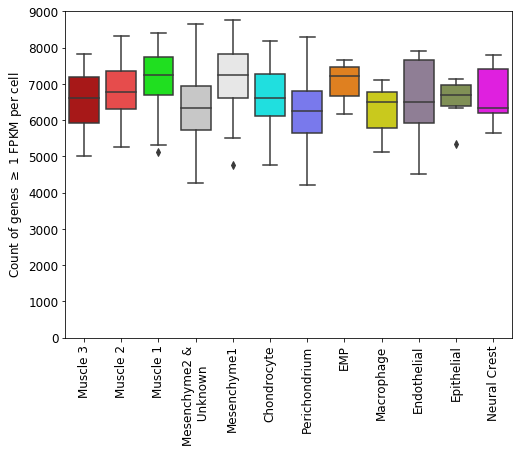

In [22]:
f2 = plot_boxplot(expressed[cluster_order])

In [23]:
c = expressed.columns.get_level_values(0)

In [24]:
c.to_series().unique()

array(['Muscle 3', 'Muscle 2', 'Muscle 1', 'Mesenchyme2 + Unknown',
       'Mesenchyme1', 'Chondrocyte', 'EMP', 'Macrophage', 'Endothelial',
       'Perichondrium', 'Epithelial', 'Neural Crest'], dtype=object)